In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
# REGEX PATTERNS FOR THE PATIENTS IDS
REGEX = r'(^\S+-.+-\S)|(Reporter intensity corrected)|(^P\d{6}$)'  # patient identifiers
Z_SCORE_REGEX = r'(^\S+-.+-\S)|(Reporter intensity corrected)|(^P\d{6}$) Z-score'
REGEX_META = r'^Identification metadata'  # to get num identified pepetides in FP intensity file

def count_df_to_density_plot_df(temp_df,identifier):
    # background = pd.DataFrame(temp_fpkm.filter(regex = cn.REGEX).to_numpy().flatten())
    background = temp_df.filter(regex = REGEX).to_numpy().flatten()
    backgournd_count_df = data_to_count_df(background,color='blue',opacity= 0.15)
    abundances = temp_df[temp_df.index == identifier]
    abundances =  abundances.filter(regex=REGEX).to_numpy()
    abundances_count_df = data_to_count_df(abundances,color='red',opacity=0.8,density=False)
    final_count_df = pd.concat([backgournd_count_df,abundances_count_df])
    final_count_df = final_count_df.sort_values(by='X')
    return final_count_df


def data_to_count_df(data:np.array, color='red',bins = 50, opacity = 0.3, density = True):
    inp = data[~np.isnan(data)]
    inp = data[np.isfinite(data)]
    hs = np.histogram(inp, bins= bins, density=density)
    counts = np.interp(hs[0], (hs[0].min(), hs[0].max()), (0, +1))
    edges = np.round(hs[1][0:len(hs[1])-1],decimals=2)
    df = pd.DataFrame(list(zip(edges, counts)))
    df.columns = ['X','Y']
    df['color'] = color
    df['opacity'] = opacity
    df['ind'] = df['X']
    return df

def unnest_proteingroups(df:pd.DataFrame) -> pd.DataFrame:
    """
    Unnest the protein_groups A;B as two separate rows with the same values
    the protein groups are the index of the the pandas dataframe df
    """
    temp_df = df
    temp_df['index'] = temp_df.index.str.split(';')
    temp_df = temp_df.explode('index')
    temp_df = temp_df.set_index('index')
    return temp_df


def get_pep_number_from_protein_name(intensity_df:pd.DataFrame,protein_name:str,regex=REGEX_META) -> pd.DataFrame:
    """ 
    gets the number of the identified pepetides from the protein name across all the patients
    :intensity_df: A pandas dataframe of the intensities with Identification metadata columns for each patient 
    :protein_name: the name of the protein
    :USAGE :
        get_pep_number_from_protein_name(fp_df,'EGFR')

    """
    premeta_df = pd.DataFrame(intensity_df.loc[protein_name,:])
    premeta_df = premeta_df.filter(regex=regex,axis=0)
    premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','', regex=True)
    premeta_df[protein_name] = premeta_df[protein_name].str.replace('detected in batch','0', regex=True) 
    premeta_df[protein_name] = pd.to_numeric(premeta_df[protein_name])
    premeta_df['Sample name'] = premeta_df.index.str.replace('Identification metadata ','', regex=True)
    premeta_df.columns = ['num_pep','Sample name']
    return premeta_df


def get_protein_intensity_per_protein(intensity_df:pd.DataFrame,protein_name:str,regex=REGEX) -> pd.DataFrame:
    df = pd.DataFrame(intensity_df.loc[protein_name,:])
    return df.filter(regex=regex,axis=0)


def get_occurence_per_protein(intensity_df:pd.DataFrame,protein_name:str,regex=REGEX) -> pd.DataFrame:
    df = pd.DataFrame(intensity_df.loc[protein_name,:])
    df = df.filter(regex=regex,axis=0)
    df = df.dropna()
    return df.count()[protein_name]


def ranodom_color_genetator(num:int) :
    """
    Generates a list with  num random colors
    
    """
    import random
    no_of_colors = num
    colors=["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)]) for j in range(10000)]
    color = random.sample(list(set(colors)),no_of_colors)
    return(color)




In [29]:
from pathlib import Path
import pandas as pd
#report_dir = '/media/kusterlab/internal_projects/active/TOPAS/WP31/Playground/Retrospective_study/2023.06.22_AhS_PAPER_COHORT'
report_dir = '/media/kusterlab/internal_projects/active/TOPAS/WP31/Playground/Retrospective_study/2023.07.31_CJ_pancancer_123'
biomarker_main_list_df = pd.read_excel('/home/amir/Desktop/Annika_files/Biomarkerlist_for Plotting.xlsx')
biomarker_list_df = biomarker_main_list_df.copy()
biomarker_list_df = biomarker_list_df[['Gene name (uniprot)'	,'other name']]
biomarker_list_df['Gene name (uniprot)'] = biomarker_list_df['Gene name (uniprot)'].str.strip()

intensity_df_path = Path(report_dir)/ Path('preprocessed_fp.csv')
intensity_df = pd.read_csv(intensity_df_path).set_index('Gene names')

In [30]:
high_confident = biomarker_main_list_df['Gene name (uniprot)'][biomarker_main_list_df['high confident detection'] == 'x'].tolist()
low_confident = biomarker_main_list_df['Gene name (uniprot)'][biomarker_main_list_df['low confident detection (1 peptide, median raw intensity <6.5,  occurrence <20)'] == 'x'].tolist()

In [31]:
occurence = []
protein_names = []
median_pep_identified = []
median_intensity = []
for i in range(len(intensity_df.index)):
    protin_name = intensity_df.index[i] 
    median_pep_identified.append(get_pep_number_from_protein_name(intensity_df,protin_name)['num_pep'].median())
    median_intensity.append(get_protein_intensity_per_protein(intensity_df,protin_name)[protin_name].median())
    occurence.append(get_occurence_per_protein(intensity_df,protin_name))
    protein_names.append(protin_name)

num_pep_df = pd.DataFrame(list(zip(protein_names,median_pep_identified)),columns=['protein_names','no_peptides_identified'])
intensity_meidans_df = pd.DataFrame(list(zip(protein_names,median_intensity)),columns=['protein_names','log10[intensity]'])
occurence_df = pd.DataFrame(list(zip(protein_names,occurence)),columns=['protein_names','occurence'])
all_data = pd.DataFrame(list(zip(protein_names,median_pep_identified,median_intensity,occurence)),columns=['protein_names',
                                                                                                            'no_peptides_identified',
                                                                                                            'log10[intensity]',
                                                                                                            'occurence'])

common_genes = [x for x in biomarker_list_df['Gene name (uniprot)'].tolist() if x  in all_data['protein_names'].tolist() ]

/home/amir/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/amir/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/amir/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/amir/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/amir/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/amir/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, ou

In [32]:
subset = all_data[all_data['protein_names'].isin(common_genes)]
final_df = subset.merge(biomarker_list_df,left_on='protein_names',right_on='Gene name (uniprot)',how='outer')
all_data = all_data.rename(columns={'log10[intensity]':'intensity'})
biomarker_df = pd.read_excel('/home/amir/Desktop/Annika_files/BKFZ_LT_Biomarker_MASTERINFORM_grouped.xlsx')
biomarker_groups = biomarker_df['Biomarker group'].unique()

In [33]:
biomarker_df['log10[intensity]'][biomarker_df['log10[intensity]'].isna()] = biomarker_df['protein_names'][biomarker_df['log10[intensity]'].isna()].apply(lambda x: all_data.intensity[all_data.protein_names.isin([x])].dropna().median() )
biomarker_df['log10[intensity]'][biomarker_df['log10[intensity]'] == 'x'] = biomarker_df['protein_names'][biomarker_df['log10[intensity]'] == 'x'].apply(lambda x: all_data.intensity[all_data.protein_names.isin([x])].dropna().median() )

/tmp/ipykernel_1352275/2941973428.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  biomarker_df['log10[intensity]'][biomarker_df['log10[intensity]'].isna()] = biomarker_df['protein_names'][biomarker_df['log10[intensity]'].isna()].apply(lambda x: all_data.intensity[all_data.protein_names.isin([x])].dropna().median() )
/tmp/ipykernel_1352275/2941973428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  biomarker_df['log10[intensity]'][biomarker_df['log10[intensity]'] == 'x'] = biomarker_df['protein_names'][biomarker_df['log10[intensity]'] == 'x'].apply(lambda x: all_data.intensity[all_data.protein_names.isin([x])].dr

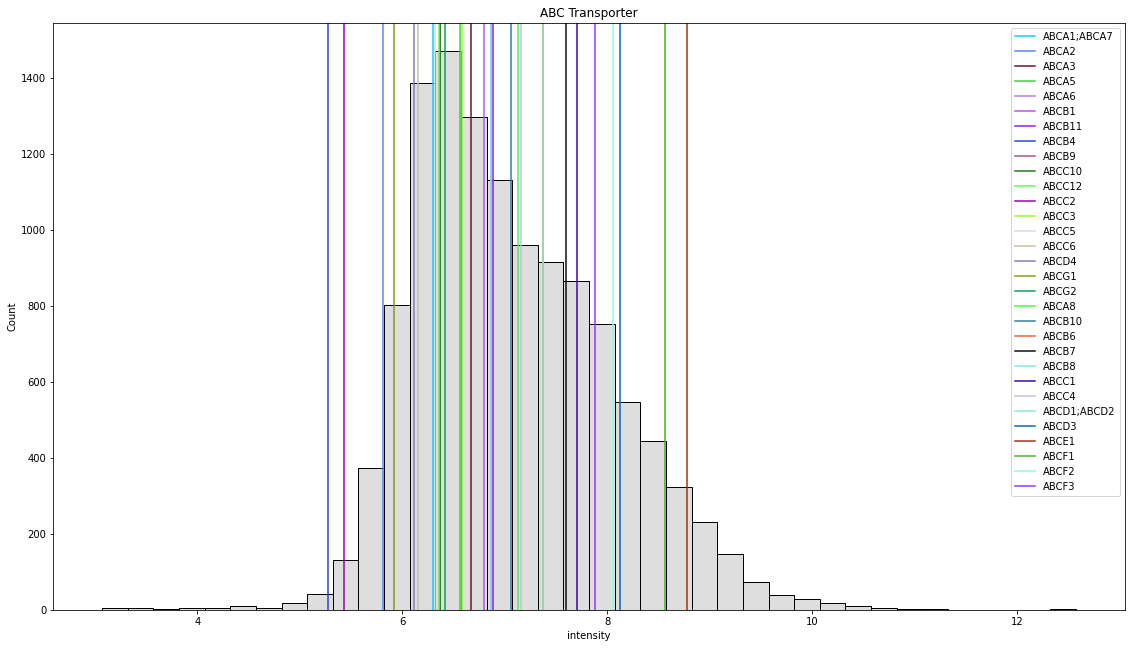

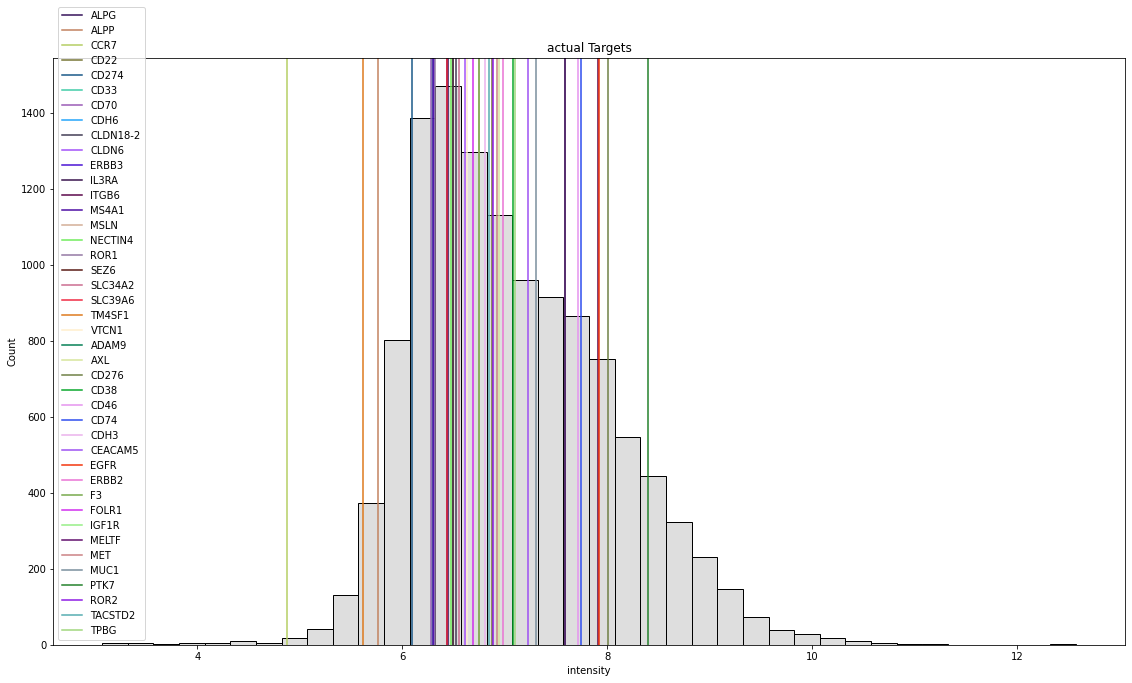

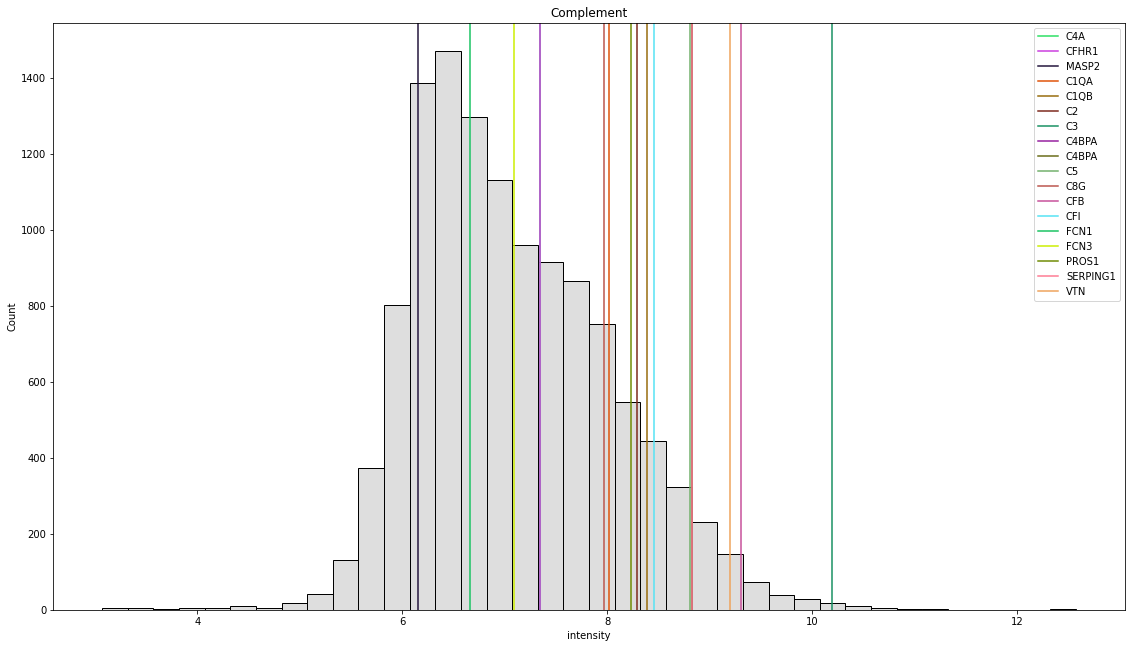

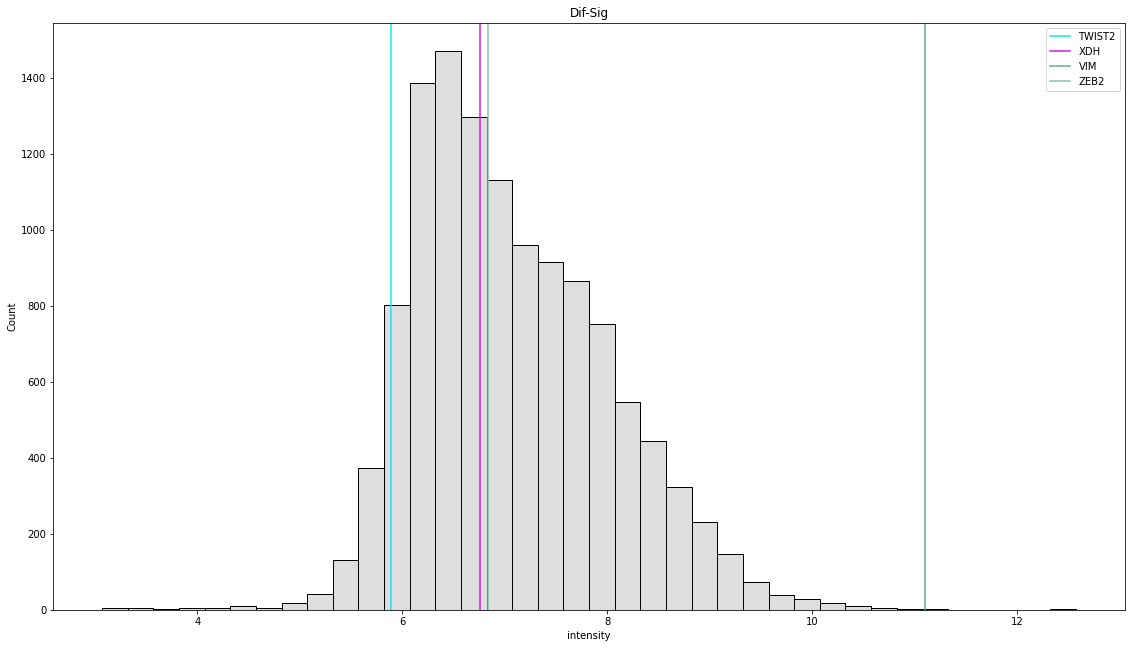

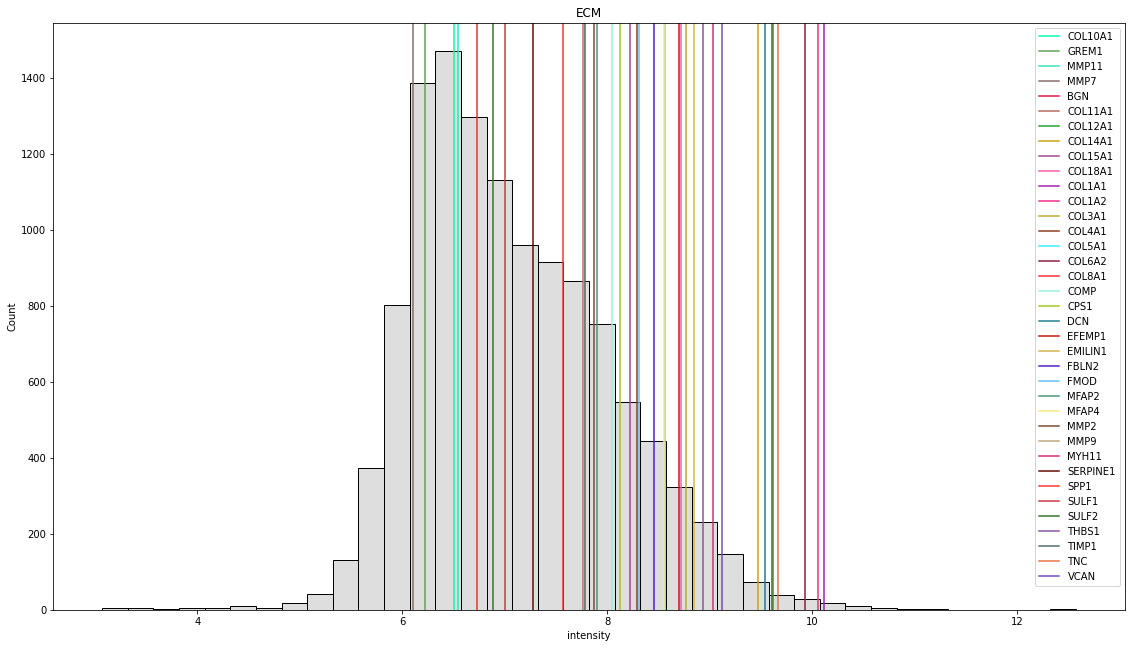

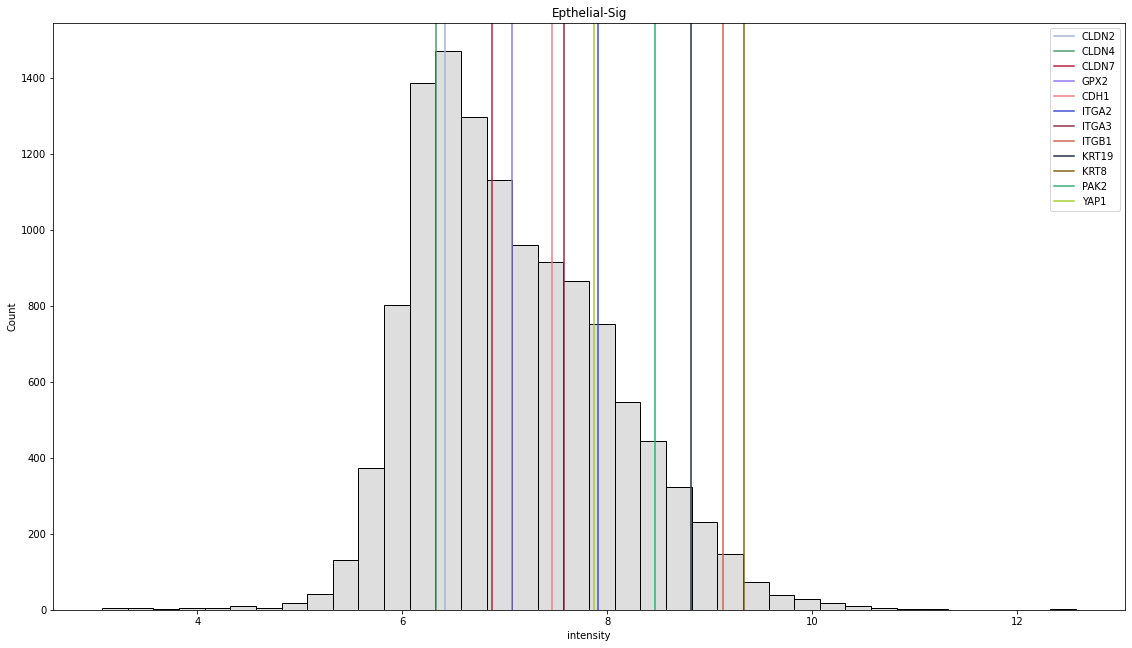

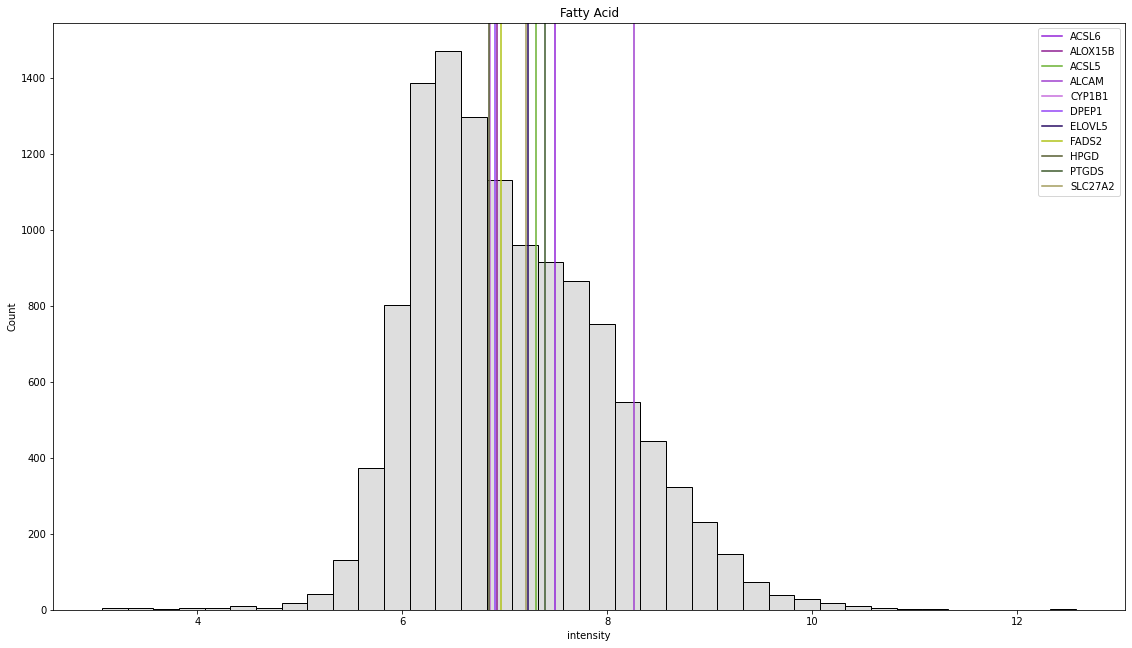

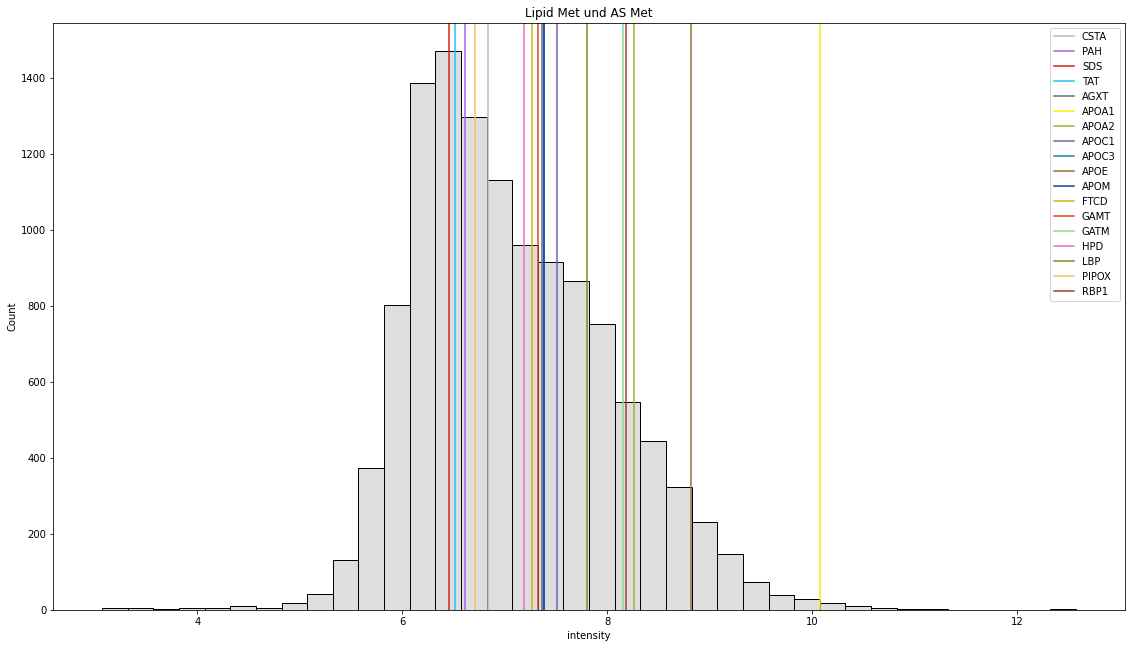

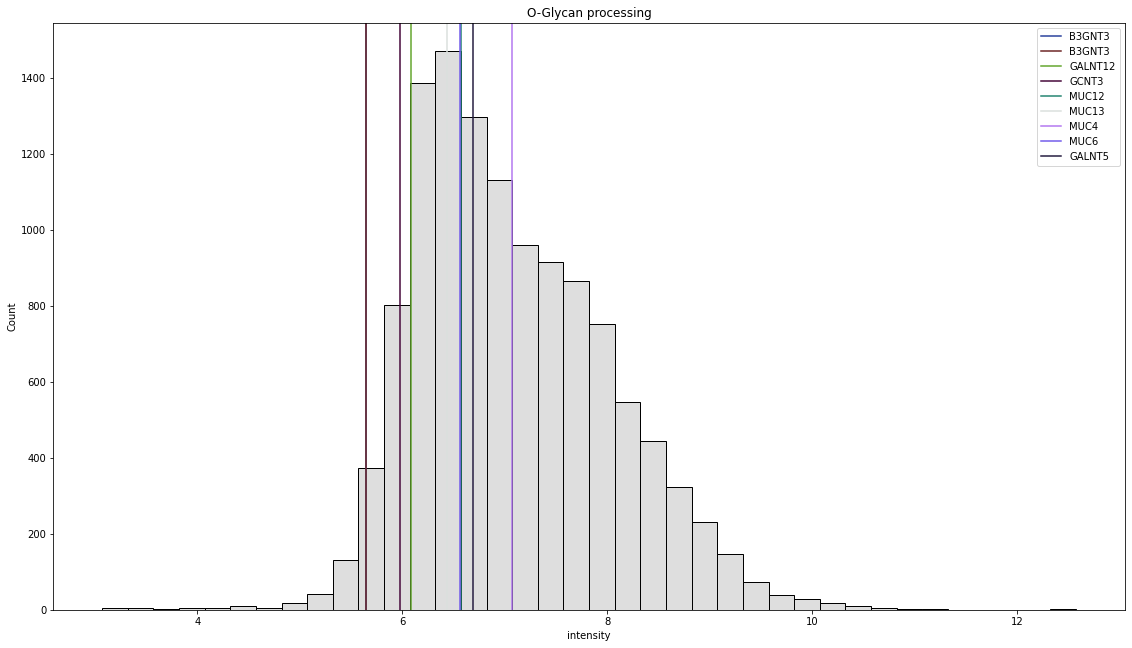

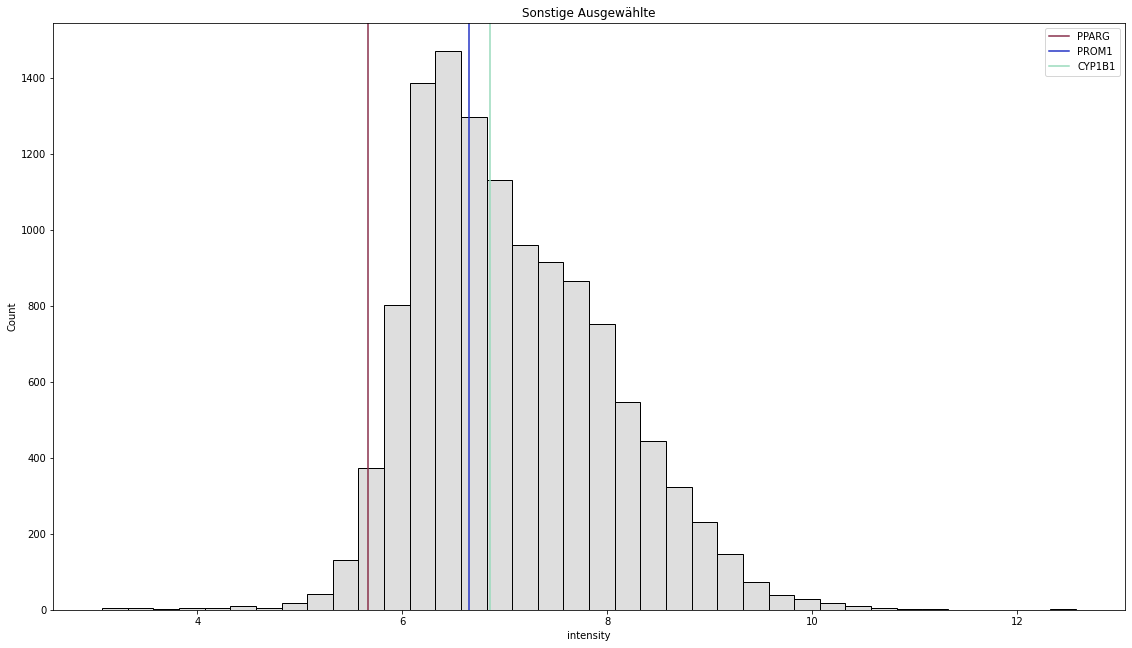

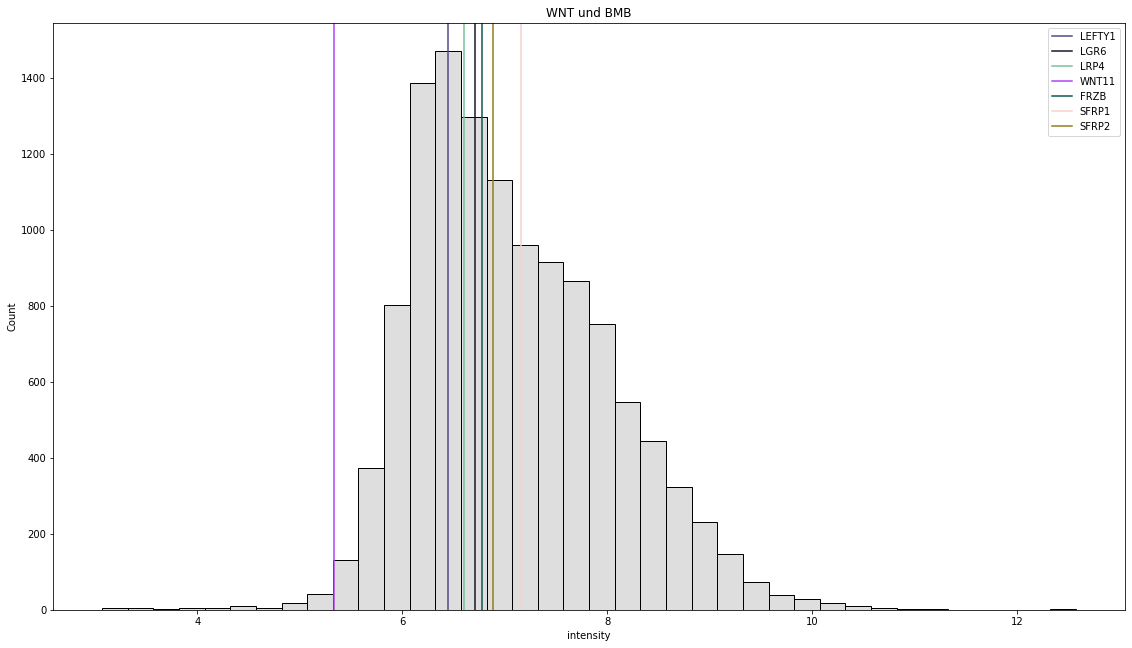

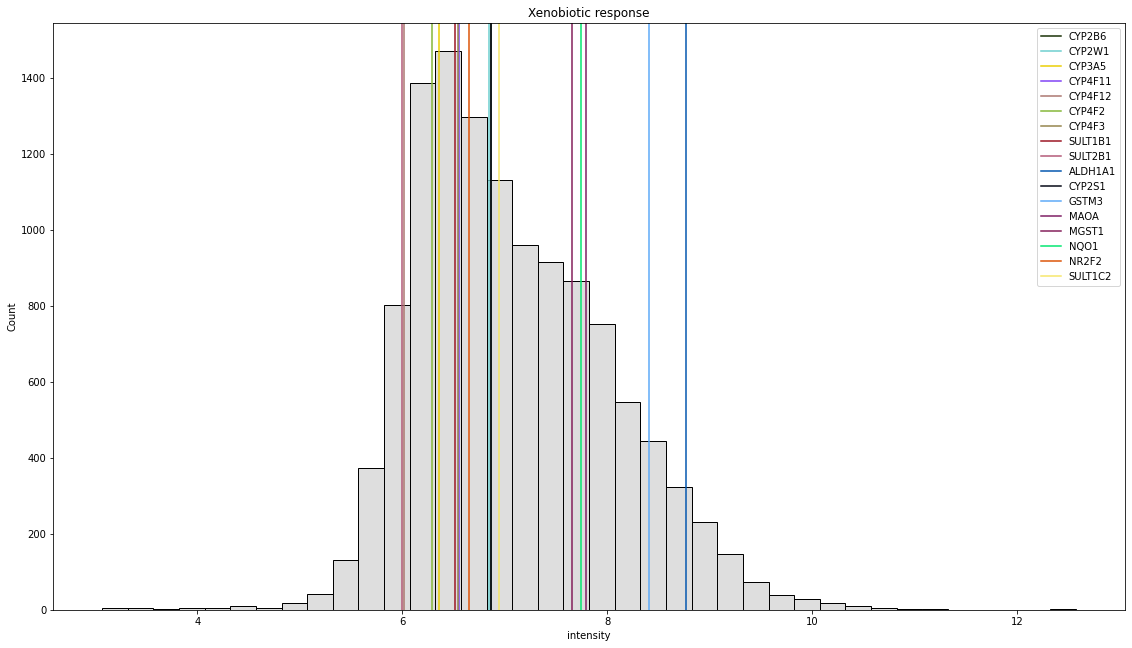

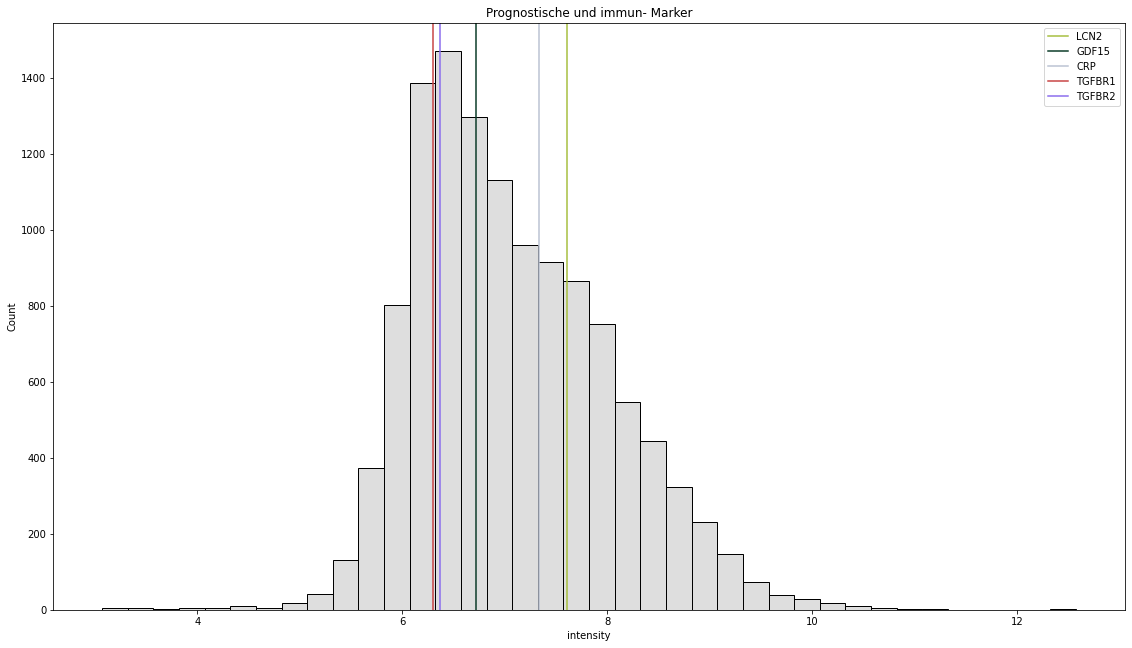

In [34]:
for j in range(len(biomarker_groups)):
    group_name = biomarker_groups[j]
    sub_df = biomarker_df[biomarker_df['Biomarker group'] == biomarker_groups[j]][['protein_names','log10[intensity]']]
    sub_df.columns = ['protein_names','intensity']
    sub_df['color'] = ranodom_color_genetator(len(sub_df))
    sub_df = sub_df.reset_index()
    fig = plt.figure(figsize=(19.20,10.80))

    im = sns.histplot(data=all_data, x="intensity",binwidth=0.25,color='lightgrey')
    for i in range(len(sub_df)):
        color = sub_df.color[i]
        intensity = sub_df.intensity[i]
        im.axvline(x = intensity, 
                                color = color,
                                alpha = 1,
                                ymin = 0, # Bottom of the plot
                                ymax = 1) # Top of the plot

        

    im.set(title=biomarker_groups[j])
    plt.legend(labels=sub_df.protein_names.tolist())
    #plt.show()
    plt.savefig(f'/home/amir/Desktop/Annika_files/FFPE_biomarker_{group_name}.svg',dpi=300)

/tmp/ipykernel_1352275/2247574431.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['color'] = ranodom_color_genetator(len(sub_df))


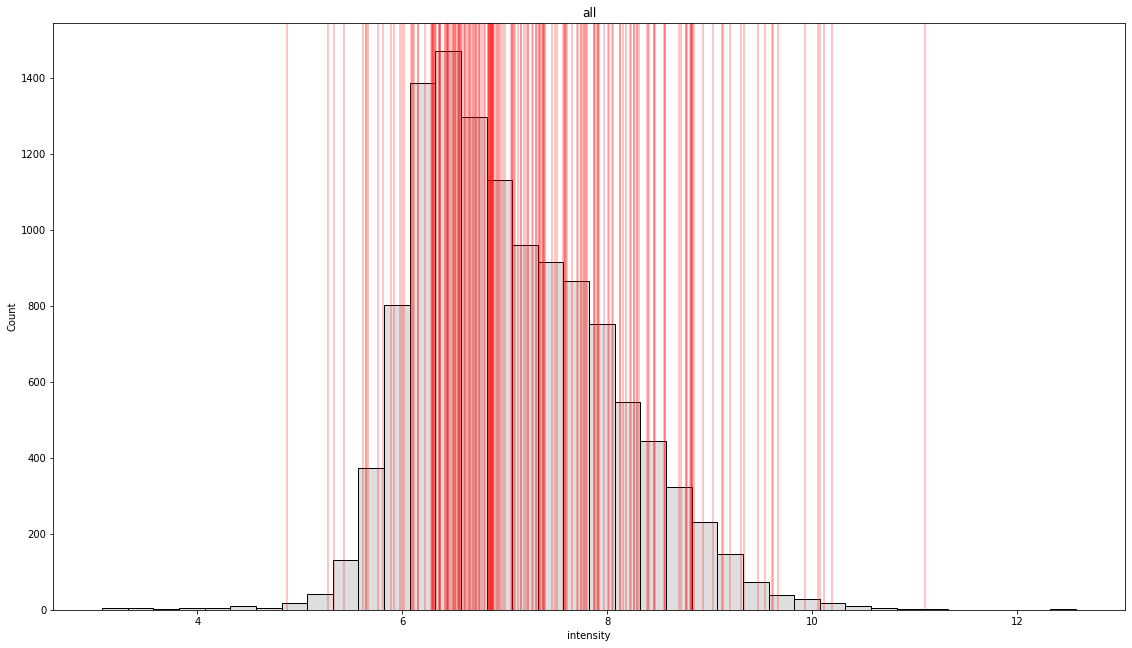

In [35]:

group_name = 'all'
sub_df = biomarker_df[['protein_names','log10[intensity]']]
sub_df.columns = ['protein_names','intensity']
sub_df['color'] = ranodom_color_genetator(len(sub_df))
sub_df = sub_df.reset_index()
fig = plt.figure(figsize=(19.20,10.80))

im = sns.histplot(data=all_data, x="intensity",binwidth=0.25,color='lightgrey')
for i in range(len(sub_df)):
    color = sub_df.color[i]
    intensity = sub_df.intensity[i]
    
    im.axvline(x = intensity, 
                            color = 'red',
                            alpha = 0.3,
                            ymin = 0, # Bottom of the plot
                            ymax = 1) # Top of the plot

    

im.set(title='all')
#plt.legend(labels=sub_df.protein_names.tolist())
#plt.show()
plt.savefig(f'/home/amir/Desktop/Annika_files/FFPE_biomarker_{group_name}.svg',dpi=300)